In [2]:
# enviroment set-up
import os
import sys
sys.path.append("..")
sys.path.append("D:\\20120321_DHBW_AZUREML\\sato")
sys.path.append("D:\\20120321_DHBW_AZUREML\\sato\\model")
from os.path import join

# set env-var
os.environ['BASEPATH'] = 'D:\\20120321_DHBW_AZUREML\\sato'
os.environ['RAW_DIR'] = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/dhbwmlc-ds12-v2/code/Users/svenlangenecker/viznet-master/raw' # path to the raw data
os.environ['SHERLOCKPATH'] = os.environ['BASEPATH']+'\\sherlock'
os.environ['EXTRACTPATH'] = os.environ['BASEPATH']+'\\extract'
#os.environ['PYTHONPATH'] = os.environ['PYTHONPATH']+':'+os.environ['SHERLOCKPATH']
#os.environ['PYTHONPATH'] = os.environ['PYTHONPATH']+':'+os.environ['BASEPATH']
os.environ['TYPENAME'] = 'type_turl'


from model import datasets
from sklearn.preprocessing import LabelEncoder
from utils import get_valid_types
import copy
import torch
from torch.utils.data import ConcatDataset


import pandas as pd
import os
from os.path import join
import sys
import matplotlib.pyplot as plt
import json
import numpy as np
from collections import OrderedDict

# LabelEncoder

label_enc = LabelEncoder()
label_enc.fit(get_valid_types(os.environ["TYPENAME"]))

C:\Users\Langenecker\.conda\envs\sato\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Langenecker\.conda\envs\sato\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\Langenecker\.conda\envs\sato\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\Langenecker\.conda\envs\sato\lib\site-packages\scipy\__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.4
  UserWarning)


LabelEncoder()

In [ ]:
label_enc.inverse_transform([73])

# Plot of 1. Sato baseline

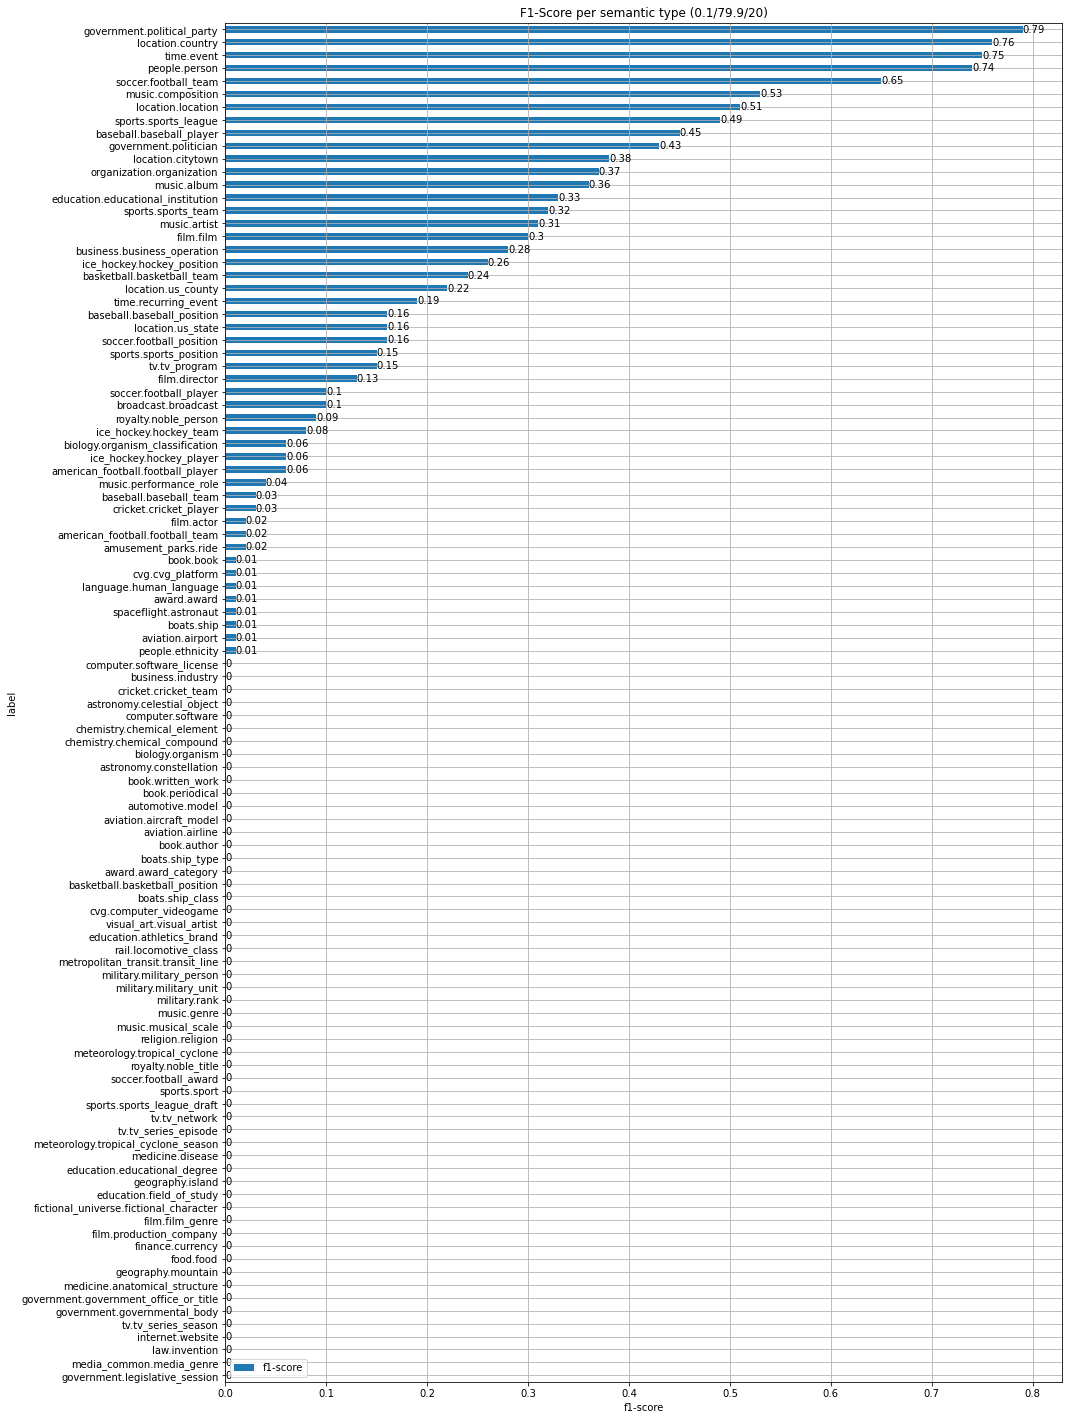

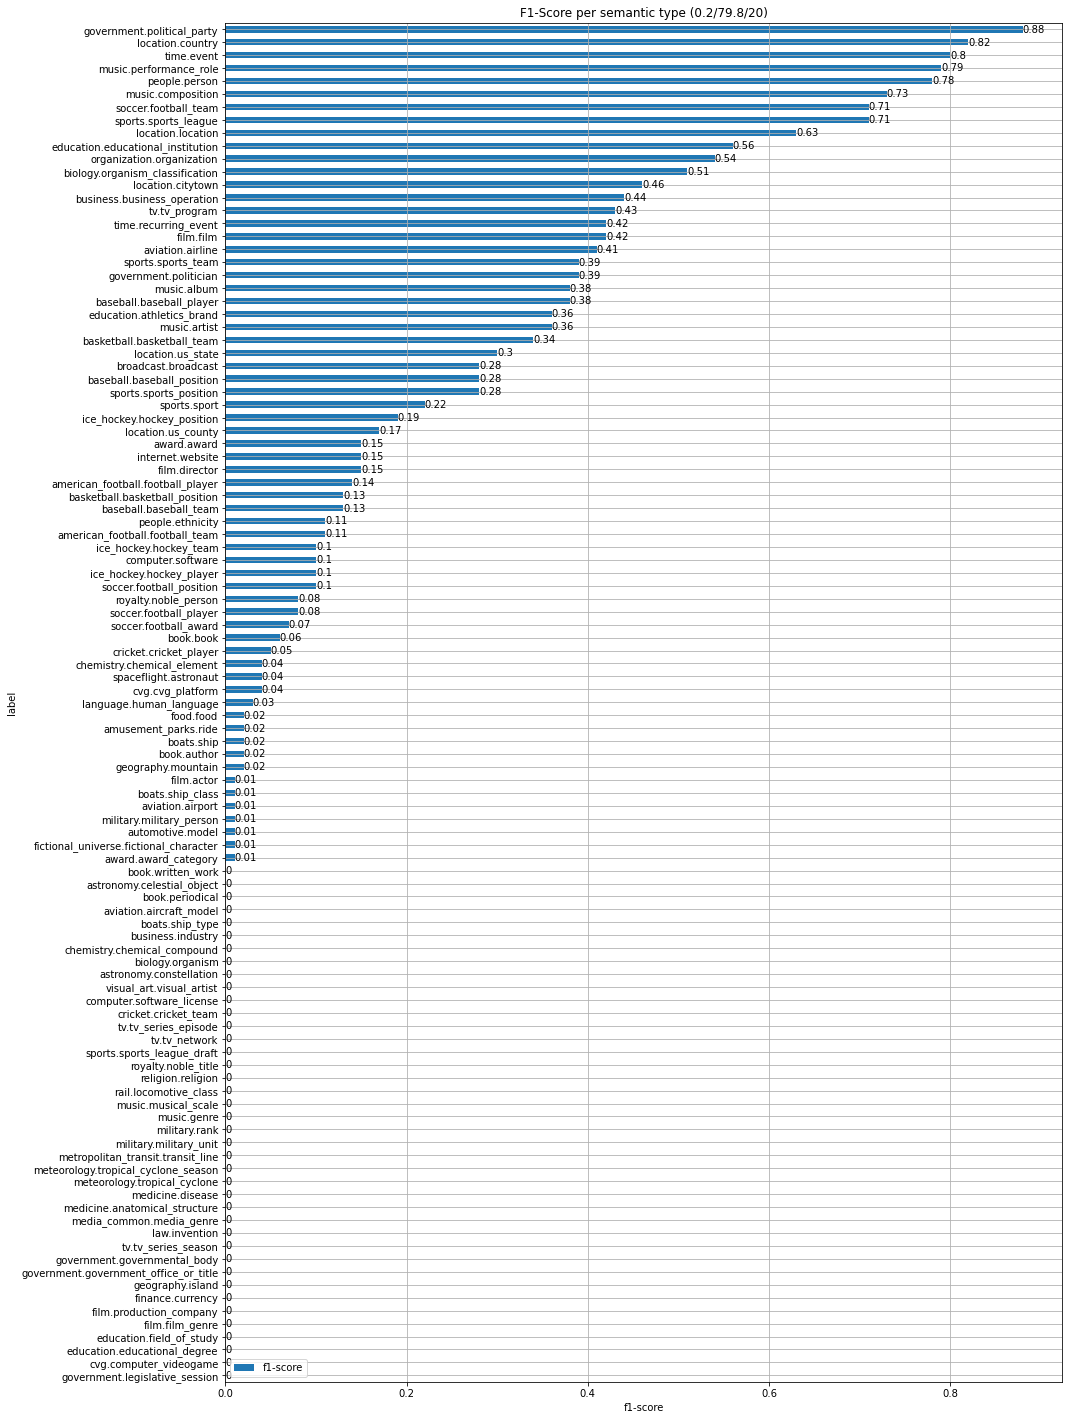

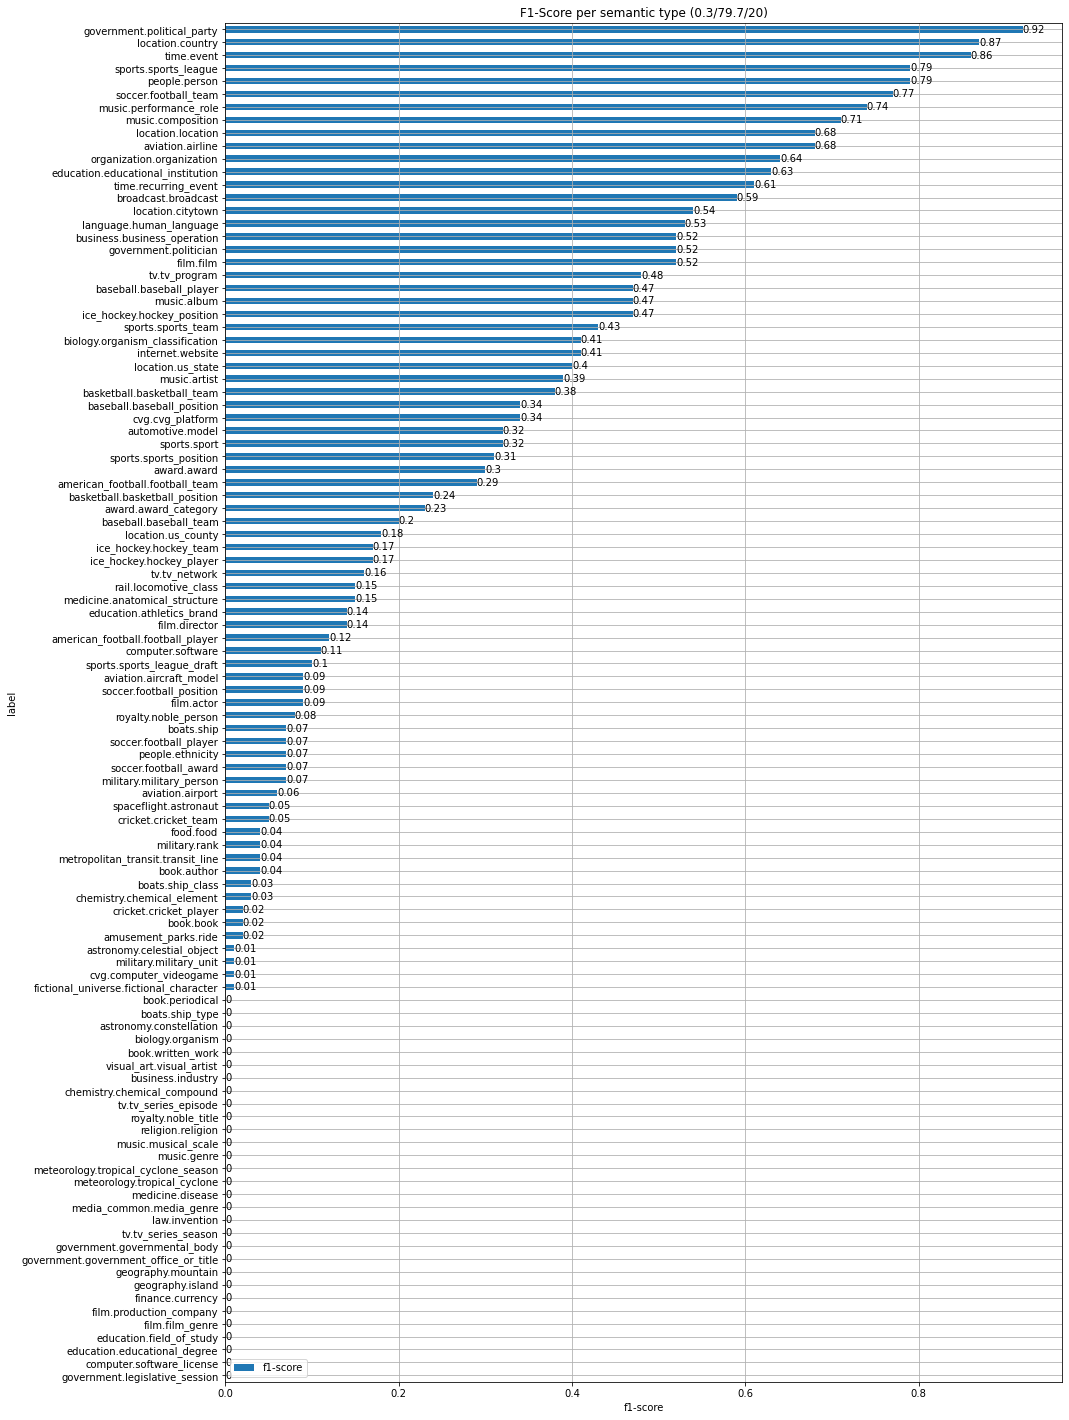

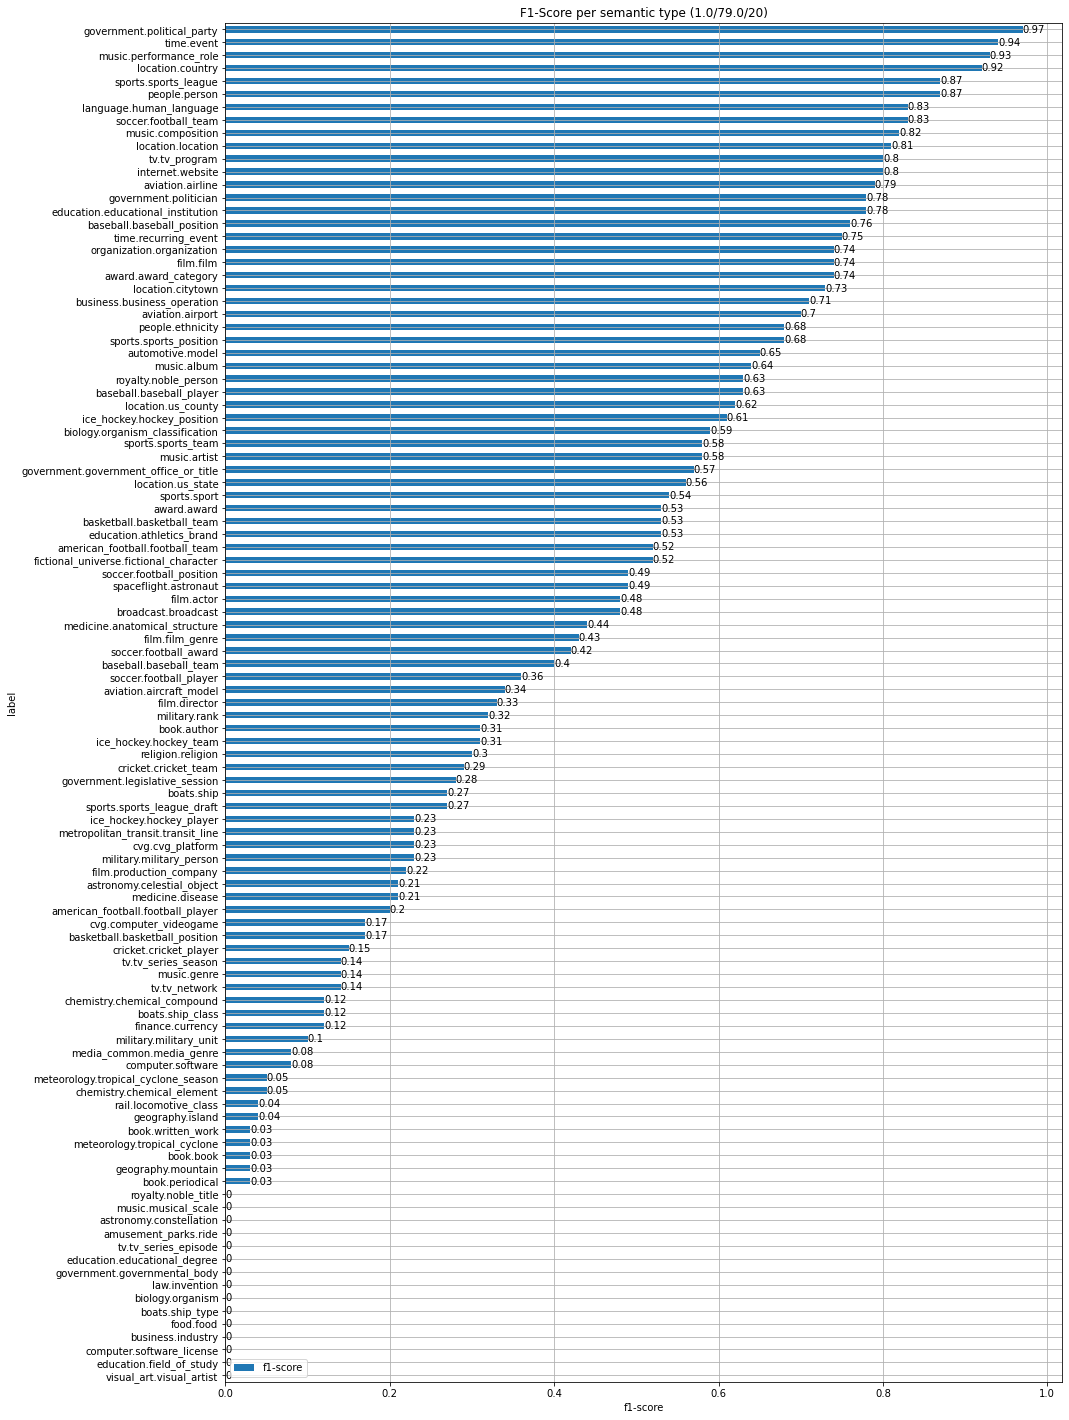

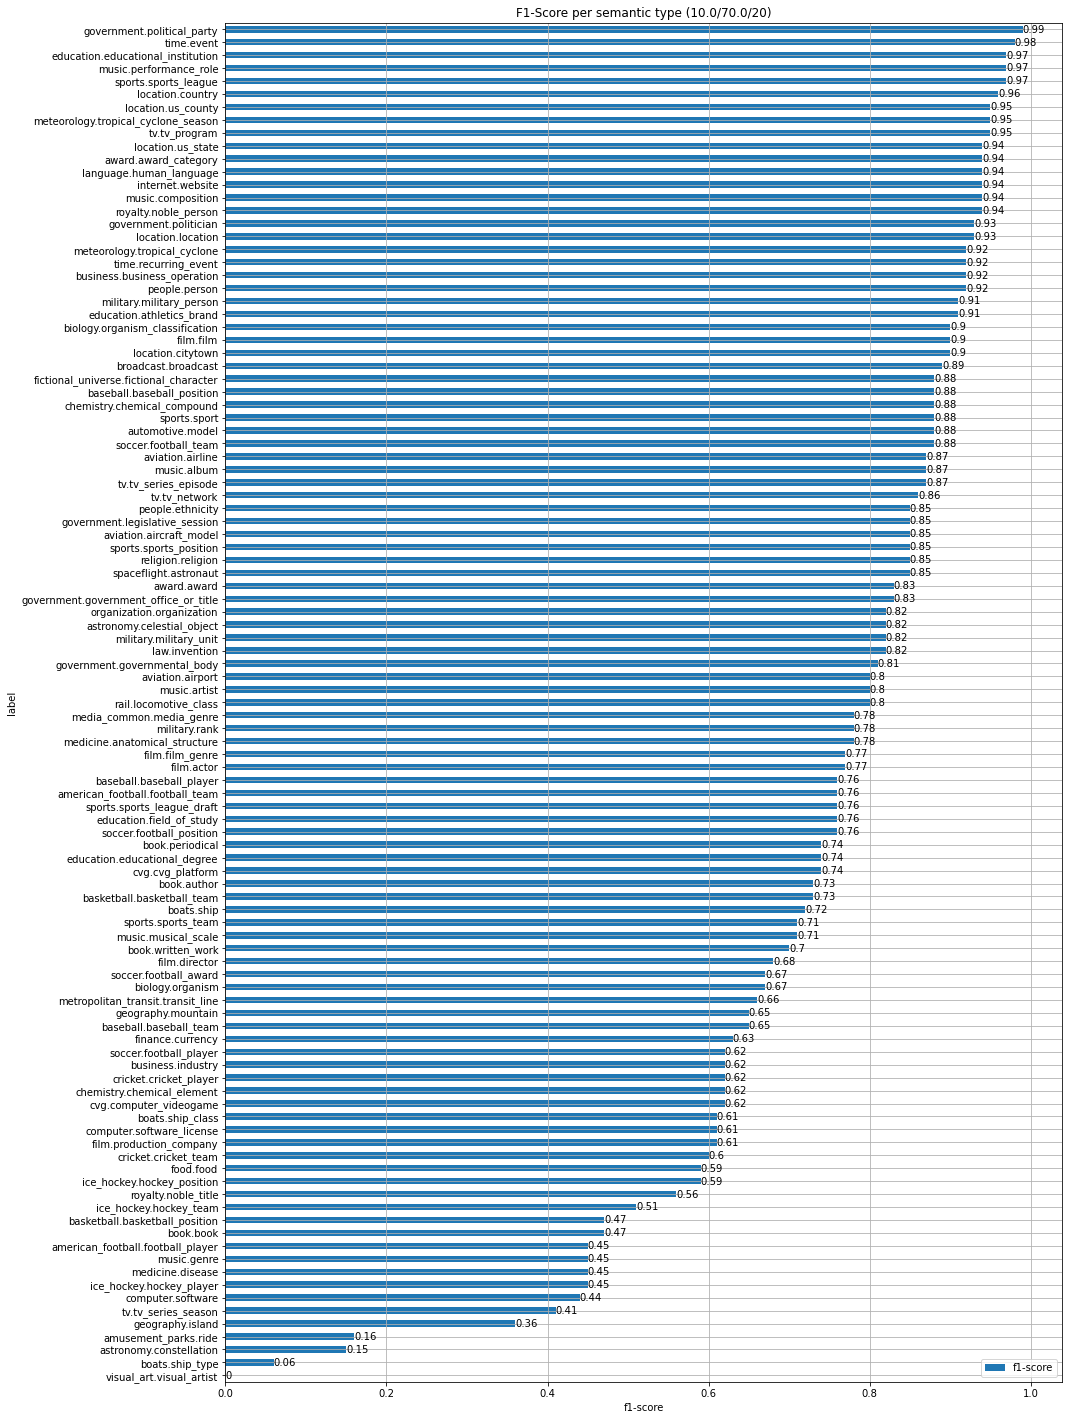

In [31]:
BASEDIR = "D:\\20120321_DHBW_AzureML\\sato"

#for labeled in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9]:
for labeled in [0.1,0.2,0.3,1.0,10.0]:
    #labeled = 1
    test = 20
    unlabeled = 100-test-labeled

    classification_result_path = join(BASEDIR, "results", "CRF_log", os.environ["TYPENAME"],
                                    f"CRF+LDA_eval_eval_labeled{labeled}_unlabeled{unlabeled}_test{test}", "outputs", f"classification_report_CRF+LDA_retrain_labeled{labeled}_unlabeled{unlabeled}_test{test}_train100.pt.json")

    with open(classification_result_path) as f:
        classification_result = json.load(f)

    #print(classification_result)

    results = []
    for label in classification_result.keys():
        if label == "accuracy" or label == "macro avg" or label == "weighted avg":
            continue
        try:
            results.append([label, classification_result[label]["f1-score"]])
        except:
            print(label)
    df = pd.DataFrame(results, columns=["label", "f1-score"]).sort_values(by="f1-score")
    df["label"] = label_enc.inverse_transform(df["label"].apply(int))
    df["f1-score"] = df["f1-score"].round(2)

    #print(df)

    ax = df.plot.barh(x="label", y="f1-score", figsize=(15,25))

    for container in ax.containers:
            ax.bar_label(container)

    plt.title(f"F1-Score per semantic type ({labeled}/{unlabeled}/{test})")
    plt.xlabel("f1-score")
    plt.grid()
    plt.savefig(join("plots",os.environ["TYPENAME"],f"score_per_sematic_type_labeled{labeled}_unlabeled{unlabeled}_test{test}.png"), bbox_inches="tight", facecolor="white", transparent=False)
    #plt.show()



In [ ]:
"""
# transfrom labels in classification report from int to semantic types
labels = list(classification_result.keys())
classification_result_classes = {}
classification_result_overall = {}
for label in labels:
    try:
        transformed_label = label_enc.inverse_transform([int(label)])[0]
        if classification_result[label]["support"] > 0:
            classification_result_classes[transformed_label] = classification_result[label]
    except:
        classification_result_overall[label] = classification_result[label]


################### Plot of results per semantic class ###########

#print(classification_result_classes)

precision_classes = list(map(lambda x: round(classification_result_classes[x]["precision"],2),classification_result_classes.keys()))
recall_classes = list(map(lambda x: round(classification_result_classes[x]["recall"],2),classification_result_classes.keys()))
f1_scores_classes = list(map(lambda x: round(classification_result_classes[x]["f1-score"],2),classification_result_classes.keys()))
support_classes = list(map(lambda x: classification_result_classes[x]["support"],classification_result_classes.keys()))

# Plot
fig, ax = plt.subplots(figsize=(20,10))

X = np.arange(0,len(classification_result_classes.keys())*2,2)
width = 0.5
precision_bar = ax.bar(X - width, precision_classes, width=width, label="precision")
recall_bar = ax.bar(X, recall_classes, width=width, label="recall")
f1_score_bar = ax.bar(X + width, f1_scores_classes, width=width, label="f1-score")

ax.set_xticks(X)
ax.set_ylabel("score")
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels(classification_result_classes.keys(), rotation=90)
ax.grid(axis="y")
ax.legend(loc=0)
ax.set_title("Scores per semantic type")

fig.tight_layout()

plt.show()

############### Plot of overall results

#print(classification_result_overall)

del classification_result_overall["accuracy"]
precision_classes = list(map(lambda x: round(classification_result_overall[x]["precision"],2),classification_result_overall.keys()))
recall_classes = list(map(lambda x: round(classification_result_overall[x]["recall"],2),classification_result_overall.keys()))
f1_scores_classes = list(map(lambda x: round(classification_result_overall[x]["f1-score"],2),classification_result_overall.keys()))

# Plot
fig, ax = plt.subplots(figsize=(20,10))

X = np.arange(0,len(classification_result_overall.keys())*1,1)
width = 0.2
precision_bar = ax.bar(X - width, precision_classes, width=width, label="precision")
recall_bar = ax.bar(X, recall_classes, width=width, label="recall")
f1_score_bar = ax.bar(X + width, f1_scores_classes, width=width, label="f1-score")
ax.set_xticks(X)
ax.set_ylabel("score")
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_xticklabels(classification_result_overall.keys())


ax.grid()
ax.legend()
ax.set_title("Scores overall")

ax.bar_label(precision_bar, padding=3)
ax.bar_label(recall_bar, padding=3)
ax.bar_label(f1_score_bar, padding=3)

fig.tight_layout()

plt.show()


############################ plots of support

# Plot
fig, ax = plt.subplots(figsize=(20,10))

X = np.arange(0,len(classification_result_classes.keys())*2,2)
width = 0.75
support_bar = ax.bar(X, support_classes, width=width, label="support")

ax.set_xticks(X)
ax.set_ylabel("support")
ax.set_xticklabels(classification_result_classes.keys(), rotation=90)
ax.grid()
ax.legend(loc=0)
ax.set_title("Support per semantic type")

ax.bar_label(support_bar, padding=3)

fig.tight_layout()

plt.show()
"""

# Plot of 2. Sato + small set of labeled data for re-training

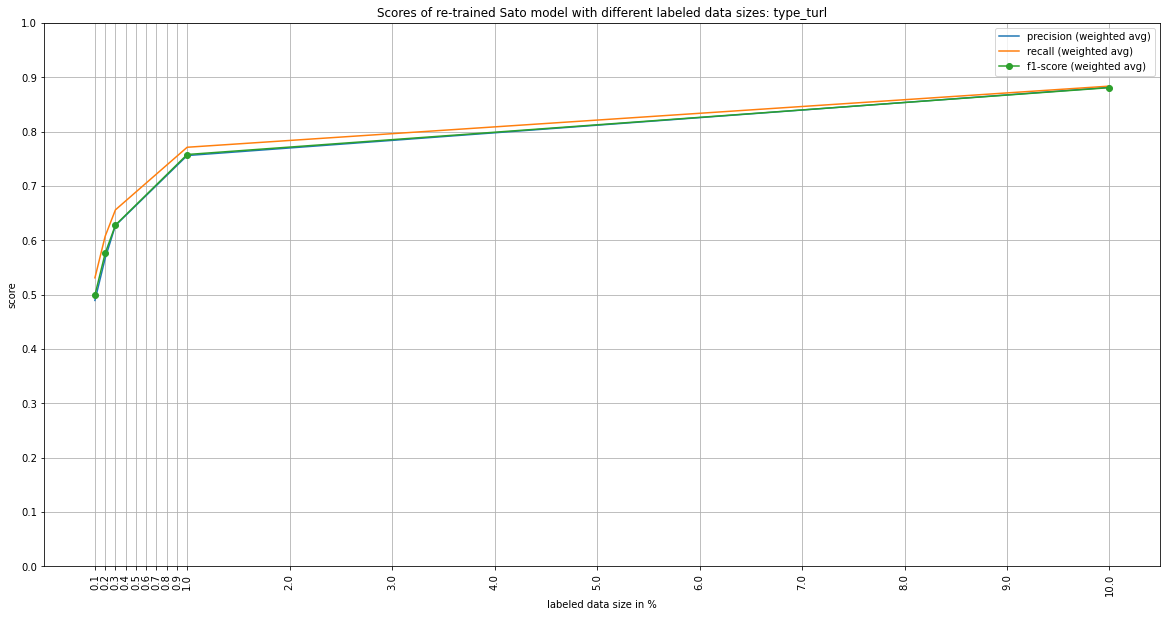

In [28]:
BASEDIR = "D:\\20120321_DHBW_AzureML\\sato"
TYPE = "type_turl"
AVG = "weighted avg"
# classification_result_path = join(BASEDIR, "results", "CRF_log", TYPE,
#                                   "CRF+LDA_eval_eval_sato_baseline_column_level_split_test20", "outputs", "classification_report_model.pt.json")

classification_results = []
labeled_data_sizes = []
for percent in np.concatenate((np.around(np.arange(0.1,1.0,0.1),1),np.arange(1,10,1),np.arange(10, 55, 5))):
#for percent in np.concatenate((np.arange(1,10,1),np.arange(10, 55, 5))):
    # if percent > 0.9:
    #     percent = int(percent)
    #print(percent)
    classification_result_path = join(BASEDIR, "results", "CRF_log", TYPE, f"CRF+LDA_eval_eval_labeled{percent}_unlabeled{100-20-percent}_test{20}",
                                      "outputs", f"classification_report_CRF+LDA_retrain_labeled{percent}_unlabeled{100-20-percent}_test{20}.pt.json")
    if TYPE == "type_turl":
        classification_result_path = join(BASEDIR, "results", "CRF_log", TYPE, f"CRF+LDA_eval_eval_labeled{percent}_unlabeled{100-20-percent}_test{20}",
                                      "outputs", f"classification_report_CRF+LDA_retrain_labeled{percent}_unlabeled{100-20-percent}_test{20}_train100.pt.json")
    try:
        with open(classification_result_path) as f:
            classification_results.append(json.load(f))
        labeled_data_sizes.append(percent)   
    except:
        continue

f1_scores_weighted = list(map(lambda x: x[f"{AVG}"]["f1-score"], classification_results))
precisions_weighted = list(map(lambda x: x[f"{AVG}"]["precision"], classification_results))
recalls_weighted = list(map(lambda x: x[f"{AVG}"]["recall"], classification_results))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(labeled_data_sizes, precisions_weighted, label=f"precision ({AVG})")
ax.plot(labeled_data_sizes, recalls_weighted, label=f"recall ({AVG})")
ax.plot(labeled_data_sizes, f1_scores_weighted, label=f"f1-score ({AVG})", marker="o")

ax.grid()
ax.legend()
plt.xlabel("labeled data size in %")
#plt.xticks(np.concatenate((np.arange(1,11,1),np.arange(10, 55, 5))))
plt.xticks(np.concatenate((np.arange(0.1,1.0,0.1),np.arange(1,11,1))), rotation=90)
plt.ylabel("score")
plt.yticks(np.arange(0,1.1,0.1))
plt.title(f"Scores of re-trained Sato model with different labeled data sizes: {TYPE}")
plt.show()

# Plot of 4. Sato retrained with EmbClus

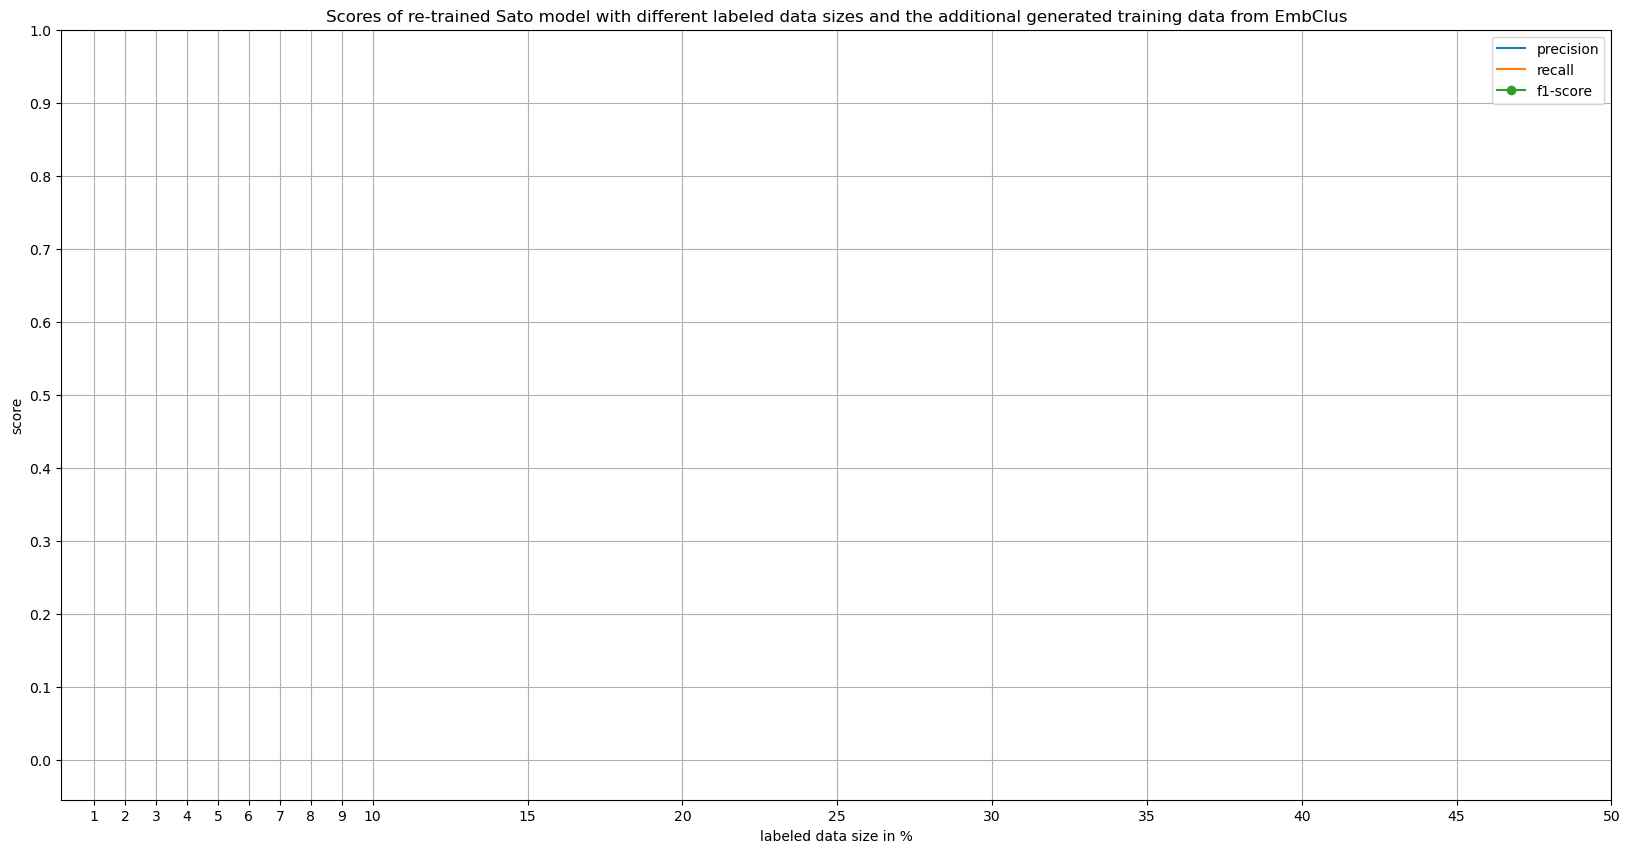

In [3]:
BASEDIR = "D:\\20120321_DHBW_AzureML\\sato"
distance_threshold = 1e-6
TYPE = "type_turl"
AVG = "weighted avg"

classification_results = []
labeled_data_sizes = []
for percent in np.concatenate((np.arange(1,10,1),np.arange(10, 55, 5))):
    #print(percent)
    classification_result_path = join(BASEDIR, "results", "CRF_log", TYPE, f"CRF+LDA_eval_eval_embclus_{distance_threshold}_labeled{percent}_unlabeled{100-20-percent}_test{20}",
                                      "outputs", f"classification_report_CRF+LDA_retrain_embclus_{distance_threshold}_labeled{percent}_unlabeled{100-20-percent}_test{20}.pt.json")
    try:
        with open(classification_result_path) as f:
            classification_results.append(json.load(f))
        labeled_data_sizes.append(percent)   
    except:
        continue

f1_scores_weighted = list(map(lambda x: x[AVG]["f1-score"], classification_results))
precisions_weighted = list(map(lambda x: x[AVG]["precision"], classification_results))
recalls_weighted = list(map(lambda x: x[AVG]["recall"], classification_results))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(labeled_data_sizes, precisions_weighted, label="precision")
ax.plot(labeled_data_sizes, recalls_weighted, label="recall")
ax.plot(labeled_data_sizes, f1_scores_weighted, label="f1-score", marker="o")

ax.grid()
ax.legend()
plt.xlabel("labeled data size in %")
plt.xticks(np.concatenate((np.arange(1,10,1),np.arange(10, 55, 5))))
plt.ylabel("score")
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Scores of re-trained Sato model with different labeled data sizes and the additional generated training data from EmbClus")
plt.show()